Tensor and numerical foundations (TensorFlow)

In [102]:
import tensorflow as tf
import numpy as np

In [103]:
# 1) Scalars, vectors, matrices, tensors
scalar = tf.constant(7) # rank-0
vector = tf.constant([10, 20, 30]) # rank-1
matrix = tf.constant([[1., 2.], [3., 4.]]) # rank-2
tensor = tf.constant([[[1],[2]], [[3],[4]]]) # rank-3 (2x2x1)
print(scalar.shape, vector.shape, matrix.shape, tensor.shape)

() (3,) (2, 2) (2, 2, 1)


In [104]:
# 2) Dtypes and casting
x = tf.constant([1.7, 7.4]) # float32 default
y = tf.constant([7, 10]) # int32 default
x16 = tf.cast(x, tf.float16) # reduced precision floats
y32 = tf.cast(y, tf.float32) # cast ints → floats

In [105]:
# 3) Indexing and shaping
rank2 = tf.constant([[10, 7], [3, 4]])
last_col = rank2[:, -1] # column slice
expanded = tf.expand_dims(rank2, -1) # add channel-like axis
squeezed = tf.squeeze(expanded, axis=-1)

In [106]:
# 4) Broadcasting & basic ops
A = tf.constant([[10., 7.], [3., 4.]])
print("A+10:\n", A + 10)
print("A*2:\n", A * 2)

A+10:
 tf.Tensor(
[[20. 17.]
 [13. 14.]], shape=(2, 2), dtype=float32)
A*2:
 tf.Tensor(
[[20. 14.]
 [ 6.  8.]], shape=(2, 2), dtype=float32)


In [107]:
# 5) Matrix multiplication rules (inner dims match)
X = tf.constant([[1, 2], [3, 4], [5, 6]], dtype=tf.float32) # (3x2)
Y = tf.constant([[7, 8], [9, 10], [11, 12]], dtype=tf.float32) # (3x2)
XtY = tf.matmul(X, tf.transpose(Y)) # (3x2) @ (2x3) -> (3x3)

In [108]:
# 6) Aggregations
E = tf.constant(np.random.randint(0, 100, size=10))
print("min:", tf.reduce_min(E).numpy(),
"max:", tf.reduce_max(E).numpy(),
"mean:", tf.reduce_mean(tf.cast(E, tf.float32)).numpy(),
"sum:", tf.reduce_sum(E).numpy())

min: 5 max: 90 mean: 47.1 sum: 471


In [109]:
# 7) One-hot encoding
idx = tf.constant([0, 1, 2, 3])
oh = tf.one_hot(idx, depth=4)

In [110]:
# 8) NumPy interop
arr = np.array([3., 7., 10.])
t = tf.constant(arr) # NumPy -> Tensor
back_to_np = t.numpy() # Tensor -> NumPy
print("OK")

OK


Regression (Neural Network predicting a number)

In [111]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [112]:
# Synthetic linear data
X = np.arange(-20, 21, 2, dtype=np.float32) # [-20, -18, ..., 20]
y = X + 10


In [113]:
# Train/test split (simple)
X_train, y_train = X[:20], y[:20]
X_test, y_test = X[20:], y[20:]

In [114]:
# 1) CREATE
model = tf.keras.Sequential([
 tf.keras.layers.Input(shape=(1,)),
 tf.keras.layers.Dense(1) # linear output for regression
])

In [115]:
# 2) COMPILE
model.compile(
 loss="mae",
 optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
 metrics=["mae"]
)

In [116]:
# 3) FIT
history = model.fit(X_train, y_train, epochs=200, verbose=0)


In [117]:
# Evaluate
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print("Test MAE:", mae)


Test MAE: 16.56256103515625


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


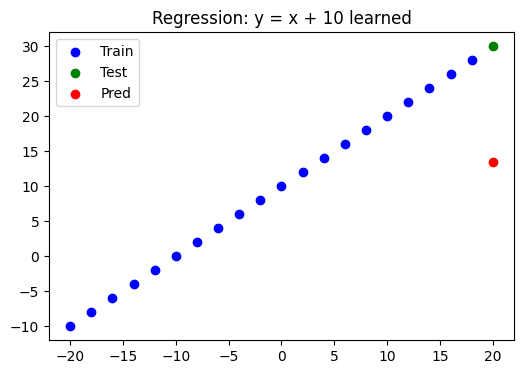

In [118]:
# Predict and visualize
y_pred = model.predict(X_test).squeeze()
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, c='b', label='Train')
plt.scatter(X_test, y_test, c='g', label='Test')
plt.scatter(X_test, y_pred, c='r', label='Pred')
plt.legend(); plt.title("Regression: y = x + 10 learned")
plt.show()

Classification (Binary + Multiclass)

Binary classification on non-linear data (circles)

In [119]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split


In [120]:
# Non-linear separable data
X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
 random_state=42)


In [121]:
# 1) CREATE (use non-linear activations + sigmoid output)
model = tf.keras.Sequential([
 tf.keras.layers.Input(shape=(2,)),
 tf.keras.layers.Dense(16, activation="relu"),
 tf.keras.layers.Dense(16, activation="relu"),
 tf.keras.layers.Dense(1, activation="sigmoid")
])


In [122]:
# 2) COMPILE
model.compile(
 loss="binary_crossentropy",
 optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
 metrics=["accuracy"]
)


In [123]:
# 3) FIT
history = model.fit(X_train, y_train, epochs=25, verbose=0)


In [124]:
# Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc:.3f}")

Test accuracy: 1.000


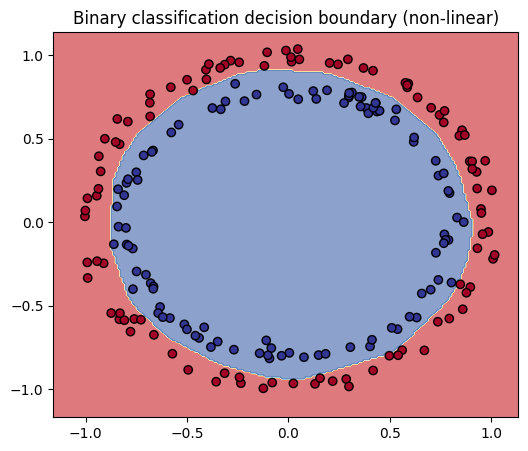

In [125]:
# Visualize decision boundary
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.1, X[:,0].max()+0.1, 200),
 np.linspace(X[:,1].min()-0.1, X[:,1].max()+0.1, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict(grid, verbose=0).reshape(xx.shape)
plt.figure(figsize=(6,5))
plt.contourf(xx, yy, (probs>0.5).astype(int), cmap=plt.cm.RdYlBu, alpha=0.6)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.RdYlBu, edgecolor='k')
plt.title("Binary classification decision boundary (non-linear)")
plt.show()


Multiclass classification with Fashion‑MNIST

In [126]:
import tensorflow as tf
import matplotlib.pyplot as plt


In [127]:
# Load Fashion-MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [128]:
# Normalize to [0,1]
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0


In [129]:
# 1) CREATE (flatten > Dense ReLU > Dense softmax)
model = tf.keras.Sequential([
 tf.keras.layers.Input(shape=(28, 28)),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dense(128, activation="relu"),
 tf.keras.layers.Dense(10, activation="softmax")
])

In [130]:
# 2) COMPILE
model.compile(
 loss="sparse_categorical_crossentropy", # labels are ints, not one-hot
 optimizer="adam",
 metrics=["accuracy"]
)


In [131]:
# 3) FIT
history = model.fit(x_train, y_train, epochs=10, validation_split=0.1, verbose=0)

In [132]:
# Evaluate
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:", acc)


Test accuracy: 0.8804000020027161


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


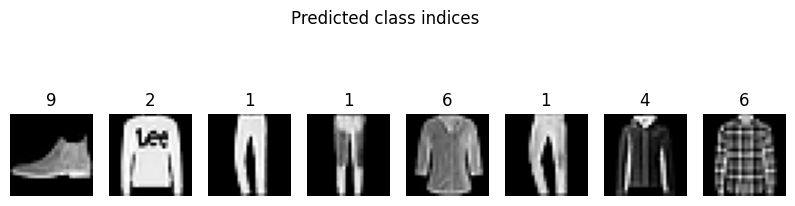

In [133]:
# Show a few preds
preds = model.predict(x_test[:8]).argmax(axis=1)
plt.figure(figsize=(10,3))
for i in range(8):
 plt.subplot(1,8,i+1)
 plt.imshow(x_test[i], cmap='gray')
 plt.title(int(preds[i]))
 plt.axis('off')
plt.suptitle("Predicted class indices"); plt.show()


CNNs for Images

In [134]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [135]:
# Use Fashion-MNIST but map 2 classes to a binary task (e.g., class 9=Ankle boot vs 7=Sneaker)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [136]:
# Keep only classes 7 and 9
train_mask = np.isin(y_train, [7, 9])
test_mask = np.isin(y_test, [7, 9])
x_train = x_train[train_mask][..., None]/255.0
y_train = (y_train[train_mask] == 9).astype(np.float32) # 1 if class 9 else 0
x_test = x_test[test_mask][..., None]/255.0
y_test = (y_test[test_mask] == 9).astype(np.float32)

In [137]:
# 1) CREATE (small CNN)
model = tf.keras.Sequential([
 tf.keras.layers.Input(shape=(28,28,1)),
 tf.keras.layers.Conv2D(16, 3, activation="relu"),
 tf.keras.layers.MaxPool2D(),
 tf.keras.layers.Conv2D(32, 3, activation="relu"),
 tf.keras.layers.MaxPool2D(),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dense(64, activation="relu"),
 tf.keras.layers.Dense(1, activation="sigmoid")
])

In [138]:
# 2) COMPILE
model.compile(
 loss="binary_crossentropy",
 optimizer="adam",
 metrics=["accuracy"]
)

In [139]:
# 3) FIT
history = model.fit(x_train, y_train, epochs=5, validation_split=0.1, verbose=0)

In [140]:
# Evaluate
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:", acc)

Test accuracy: 0.9714999794960022


Transfer Learning (Feature Extraction)

In [141]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [142]:
# Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [143]:
# Keep classes 0,1,2 only
mask_train = (y_train < 3).flatten()
mask_test = (y_test < 3).flatten()
x_train = x_train[mask_train].astype("float32")/255.0
y_train = y_train[mask_train].flatten()
x_test = x_test[mask_test].astype("float32")/255.0
y_test = y_test[mask_test].flatten()

In [144]:
# Small CNN model
model = models.Sequential([
layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(32,32,3)),
layers.MaxPooling2D(),
layers.Conv2D(64, (3,3), activation="relu", padding="same"),
layers.MaxPooling2D(),
layers.Conv2D(128, (3,3), activation="relu", padding="same"),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(64, activation="relu"),
layers.Dense(3, activation="softmax")
])
model.compile(
optimizer="adam",
loss="sparse_categorical_crossentropy",
metrics=["accuracy"]
)

In [145]:
# Train
history = model.fit(
x_train, y_train,
epochs=5,
batch_size=64,
validation_split=0.1,
verbose=1
)


Epoch 1/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7221 - loss: 0.6565 - val_accuracy: 0.8307 - val_loss: 0.4472
Epoch 2/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8330 - loss: 0.4173 - val_accuracy: 0.8753 - val_loss: 0.3486
Epoch 3/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8708 - loss: 0.3348 - val_accuracy: 0.8787 - val_loss: 0.3170
Epoch 4/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8901 - loss: 0.2810 - val_accuracy: 0.8940 - val_loss: 0.2875
Epoch 5/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9008 - loss: 0.2599 - val_accuracy: 0.9067 - val_loss: 0.2624


In [146]:
# Evaluate
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy (tiny CNN):", acc)

Test accuracy (tiny CNN): 0.890666663646698
